# Imports & Initialization

#########################################################
- Coded by Eii Chee Hieng, Hazel Lim Benin, Ong Chan Meng
#########################################################

In [1]:
import os
import csv
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import time
import torchinfo
import matplotlib.pyplot as plt
import seaborn as sns
from torchinfo import summary
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from torchvision.transforms.functional import to_pil_image, to_tensor
from skimage import color, data, exposure
from torchvision.models import ResNet18_Weights

In [2]:
print(os.getcwd())
data_path = os.getcwd() + '/Datasets/TSRD'
os.chdir(data_path)

/Users/17hieng/Programming/DL


# Init Parameters

########################################################
- Coded by Eii Chee Hieng
########################################################

In [3]:
IMG_SIZE = 60
IMG_HEIGHT = IMG_SIZE
IMG_WIDTH = IMG_SIZE
channels = 3

SPLIT_RATIO = 0.8
BATCH_SIZE = 32

NUM_EPOCH=50
LEARNING_RATE=0.001
STEP_SIZE=1
DECAY_RATE=1 - 5e-5

MAX_NO_IMG_PER_CLASS = 3000

DATA_AUGMENTATION_SPEC = transforms.Compose([
    transforms.RandomRotation(degrees=10),  # Rotation range
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=0.15, scale=(0.85, 1.15)),
    transforms.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.1), 
    transforms.ToTensor()
])

In [4]:
TRAIN_PATH = data_path + '/Train'
TEST_PATH = data_path + '/Test'
EXTERNAL_TEST_PATH = data_path + '/External_Test'

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
elif torch.backends.mps.is_available():
    device = torch.device("mps") 
else:
    device = torch.device("cpu") 

### Map Sign Names to Classes

########################################################
- Coded by Ong Chan Meng
########################################################

In [6]:
labels_dictionary = None
with open(data_path + '/mapSignnamesToClass.csv', 'r') as file:
  reader = csv.reader(file)
  next(reader, None)
  labels_dictionary = {int(row[0]): row[1] for row in reader}

print(labels_dictionary)

{0: 'Speed limit (5km/h)', 1: 'Speed limit (15km/h)', 2: 'Speed limit (30km/h)', 3: 'Speed limit (40km/h)', 4: 'Speed limit (50km/h)', 5: 'Speed limit (60km/h)', 6: 'Speed limit (70km/h)', 7: 'Speed limit (80km/h)', 8: 'Driving straight ahead or turning left prohibited', 9: 'Driving straight ahead or turning right prohibited', 10: 'Driving straight ahead prohibited', 11: 'Turning left prohibited', 12: 'Turning left or right prohibited', 13: 'Turning right prohibited', 14: 'Overtaking prohibited', 15: 'Turning around prohibited', 16: 'Cars prohibited', 17: 'Using the horn prohibited', 18: 'End of speed limit (40km/h)', 19: 'End of speed limit (50km/h)', 20: 'Driving straight ahead or turning right mandatory', 21: 'Driving straight ahead mandatory', 22: 'Turning left mandatory', 23: 'Turning left or right mandatory', 24: 'Turning right mandatory', 25: 'Passing left mandatory', 26: 'Passing right mandatory', 27: 'Mandatory direction of the roundabout', 28: 'Mandatory lane for cars', 29: '

In [7]:
Train_annotation = pd.read_csv(f'{data_path}/Train.txt', delimiter=';', header=None)
Test_annotation = pd.read_csv(f'{data_path}/Test.txt' , delimiter=';', header=None)

# 8th column is Category Code
NUM_CATEGORIES = Train_annotation[7].value_counts().count()
NUM_CATEGORIES

np.int64(58)

# Load Data

########################################################
- Coded by Ong Chan Meng
  
########################################################

## Training Data

In [31]:
image_data = []
image_labels = []

images = os.listdir(TRAIN_PATH)

transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor()
])

for img in images:
  # Skip macOS hidden file
  if img.split('_')[0] == '.DS':
      continue

  # Obtain image's class
  i = int(img.split('_')[0])
  try:
      image = cv2.imread(os.path.join(TRAIN_PATH, img))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = Image.fromarray(image, 'RGB')

      # Apply transformations if any
      if transform:
          image = transform(image)

      # STORE IMAGE AND IT'S LABEL
      image_data.append(image)
      image_labels.append(i)
  except Exception as e:
      print(f"Error in {img}: {e}")

print(len(image_data), len(image_labels))

4170 4170


## Test Data

In [32]:
test_labels = Test_annotation[7].values
test_images = Test_annotation[0].values

data = []

for img in test_images:
    # Skip macOS hidden file
    if img.split('_')[0] == '.DS':
        continue

    try:
        # Construct full image path
        img_path = os.path.join(TEST_PATH, img)

        # Read image using OpenCV
        image = cv2.imread(img_path)

        # Check if image was read correctly
        if image is None:
            print(f"Failed to load image {img_path}")
            continue

        # Convert color from BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Convert to PIL Image
        image = Image.fromarray(image, 'RGB')

        # Resize the image
        if transform:
          image = transform(image)

        # Append to the list
        data.append(image)

    except Exception as e:
        print(f"Error processing {img}: {e}")

X_test = data

print(f"Processed {len(X_test)} images")

Processed 1994 images


### Shuffle Training Data

########################################################
- Coded by Ong Chan Meng
########################################################

In [33]:
import random
random.seed(42)
combined = list(zip(image_data, image_labels))
random.shuffle(combined)
image_data[:], image_labels[:] = zip(*combined)


### Split train & validation set

########################################################
- Coded by Ong Chan Meng
########################################################

In [34]:
split_ratio = SPLIT_RATIO

split_index = int(len(image_data) * split_ratio)
X_train = image_data[:split_index]
Y_train = image_labels[:split_index]
X_val = image_data[split_index:]
Y_val = image_labels[split_index:]

print("Train data:", len(X_train))
print("Validation data:", len(X_val))

Train data: 3336
Validation data: 834


In [35]:
#Saving the old y_train and y_val for future use
Y_train = torch.tensor(Y_train)
Y_val = torch.tensor(Y_val)
Y_test = torch.tensor(test_labels)

y_train_old = Y_train.clone()
y_val_old = Y_val.clone()
y_test_old = Y_test.clone()

Y_train = nn.functional.one_hot(Y_train, NUM_CATEGORIES).float()
Y_val = nn.functional.one_hot(Y_val, NUM_CATEGORIES).float()
Y_test = nn.functional.one_hot(Y_test, NUM_CATEGORIES).float()

print(Y_train.shape)
print(Y_val.shape)

torch.Size([3336, 58])
torch.Size([834, 58])


In [36]:
Y_test = torch.tensor(test_labels)
y_test_old = Y_test.clone()
Y_test = nn.functional.one_hot(Y_test, NUM_CATEGORIES).float()

## Data summary

########################################################
- Coded by Hazel Lim Benin
########################################################

In [37]:
n_train = len(X_train)
n_valid = len(X_val)
n_test = len(X_test)

image_shape = X_train[0].shape

n_labels = NUM_CATEGORIES

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of labels/classes =", n_labels)

Number of training examples = 3336
Number of validation examples = 834
Number of testing examples = 1994
Image data shape = torch.Size([3, 60, 60])
Number of labels/classes = 58


## Sample

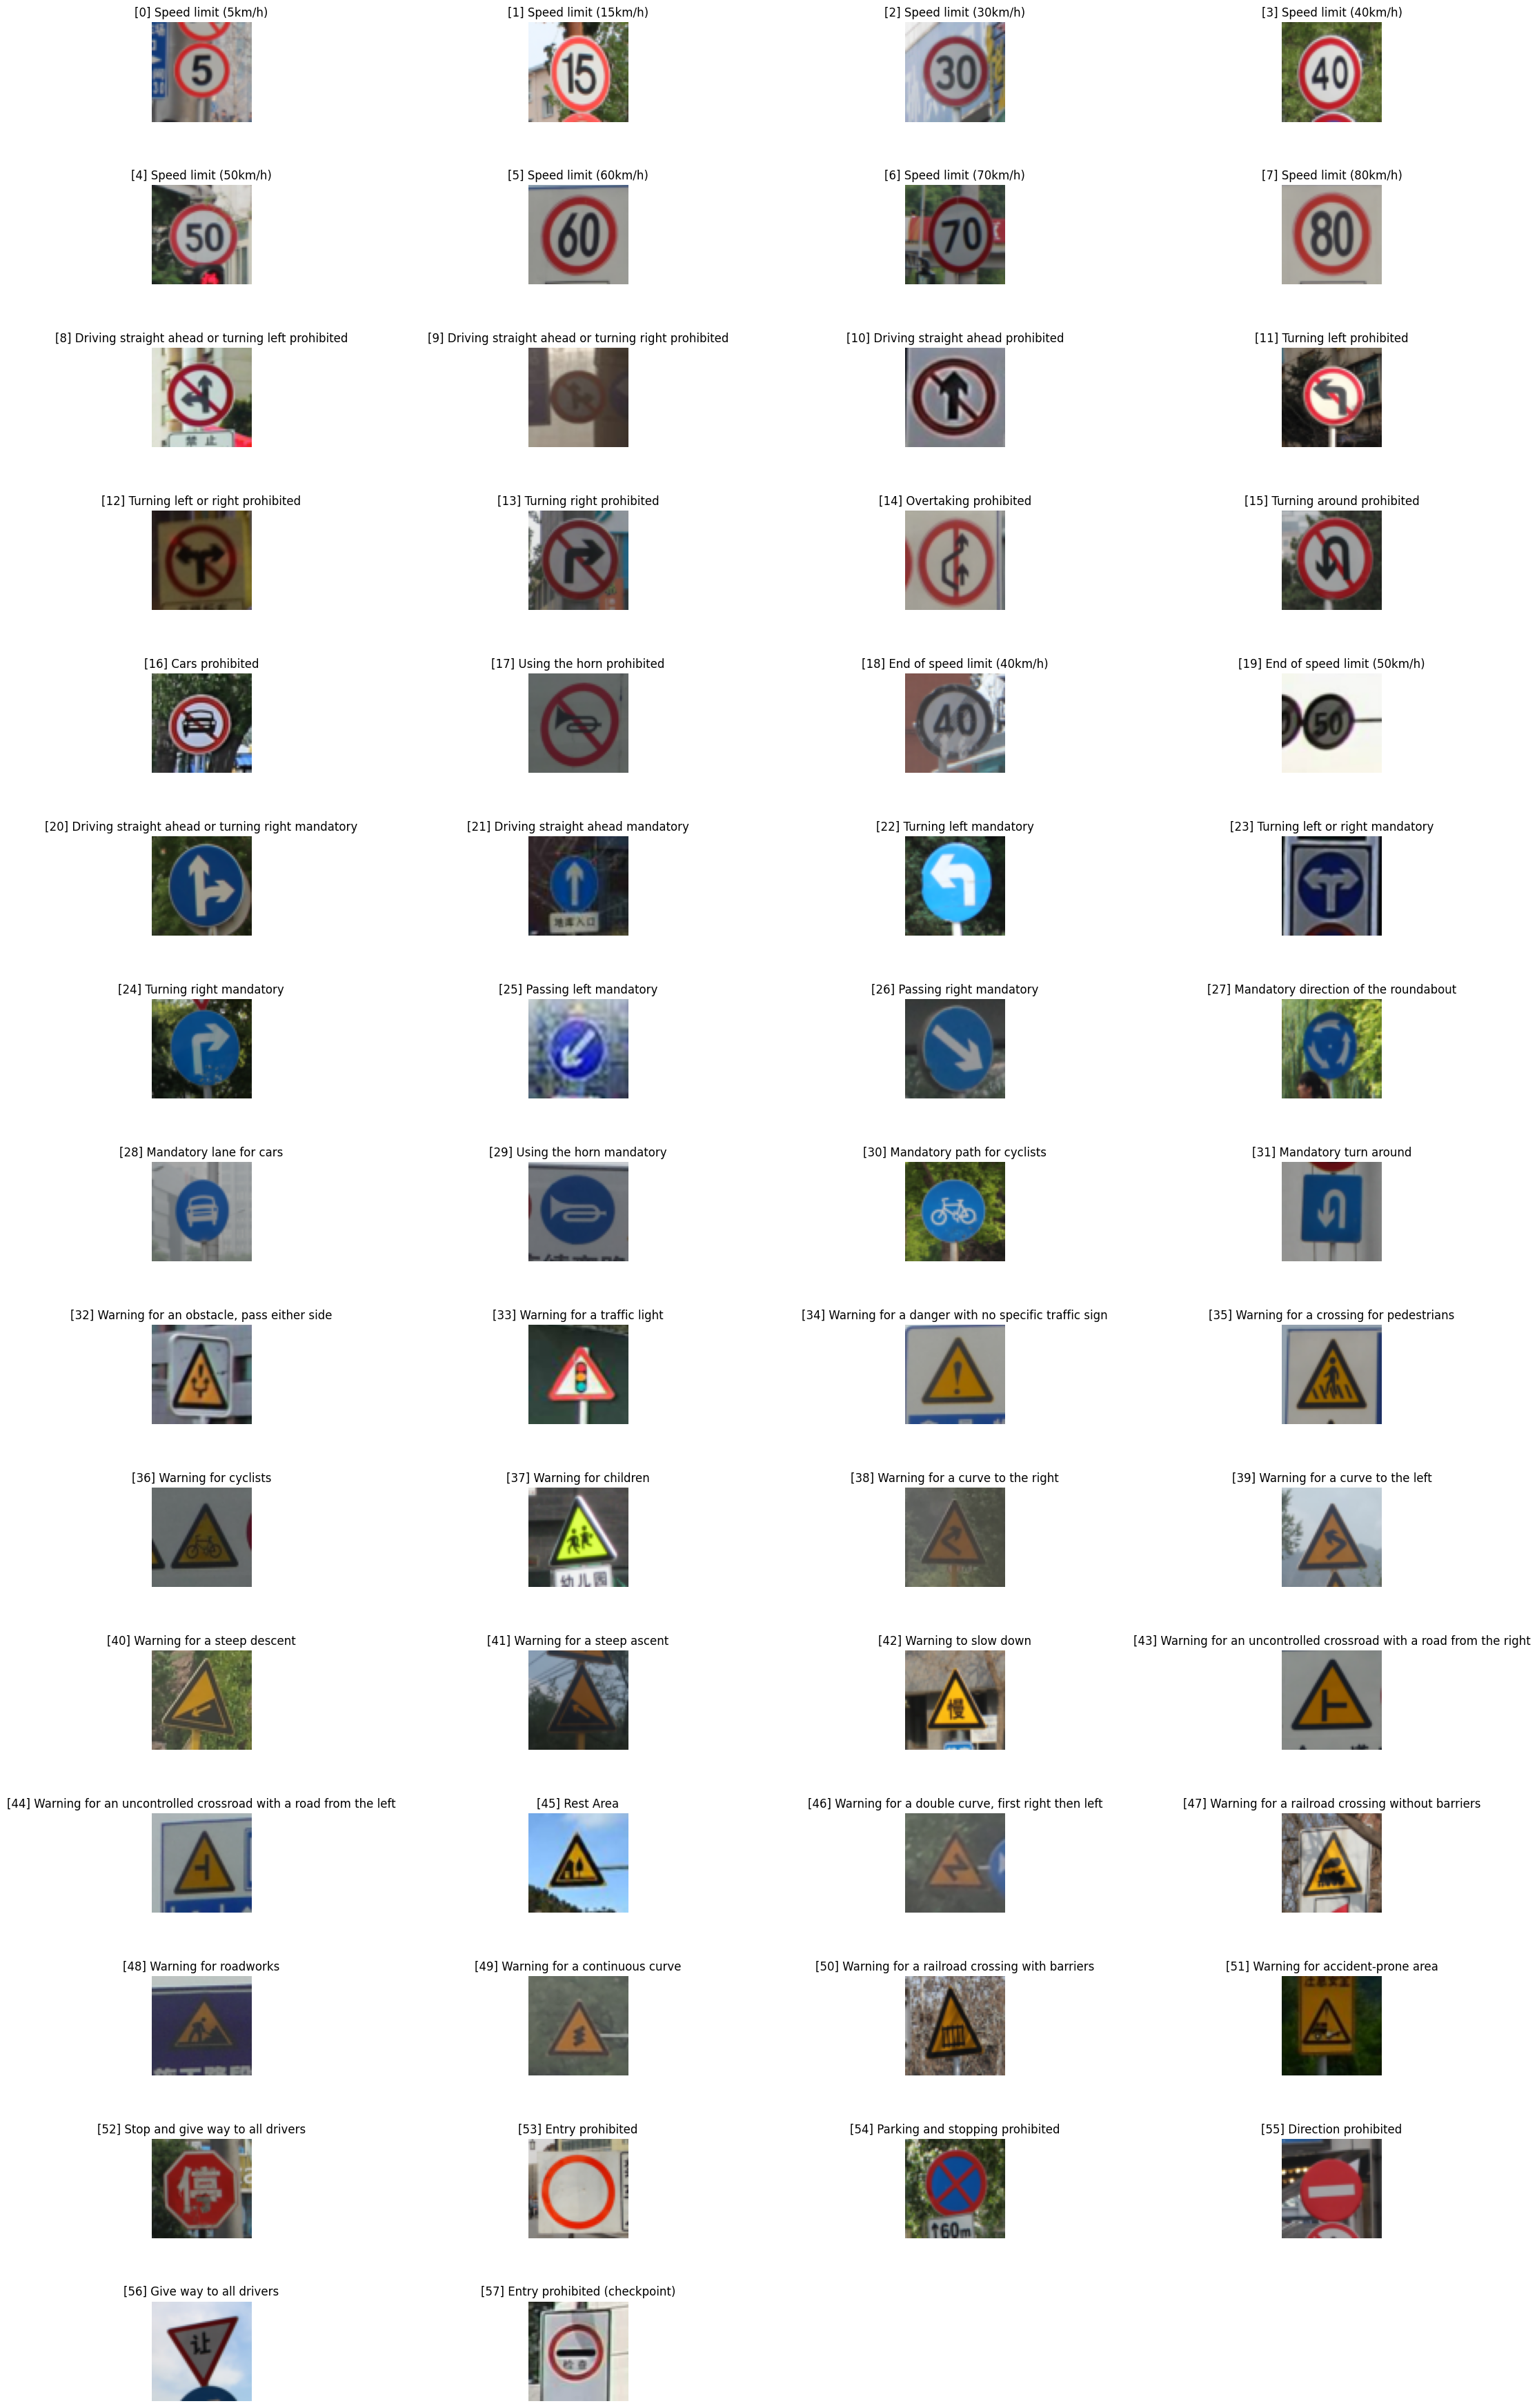

Available keys in labels_dictionary: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57])


In [38]:
# Create figure
fig = plt.figure(figsize=(22, 35), tight_layout={'h_pad': 5})

for i in range(NUM_CATEGORIES):
    # Get the indices of all occurrences of the label i
    indices = torch.where(y_train_old == i)[0]

    # Check if there are any occurrences and take the first one
    if indices.numel() > 0:
        image_key = indices[0].item()

        # Get the image tensor and permute to (H, W, C) for visualization
        img = X_train[image_key].permute(1, 2, 0).numpy()

        # Create subplot
        ax = fig.add_subplot(int(NUM_CATEGORIES / 4) + 1, 4, i + 1)
        ax.imshow(img)

        # Handle missing keys in labels_dictionary
        label_name = labels_dictionary.get(i, "Unknown Label")
        ax.set_title(f"[{i:d}] {label_name}")
        ax.axis('off')  # Hide axis for better visualization

plt.show()

# Print the keys in labels_dictionary for debugging
print("Available keys in labels_dictionary:", labels_dictionary.keys())

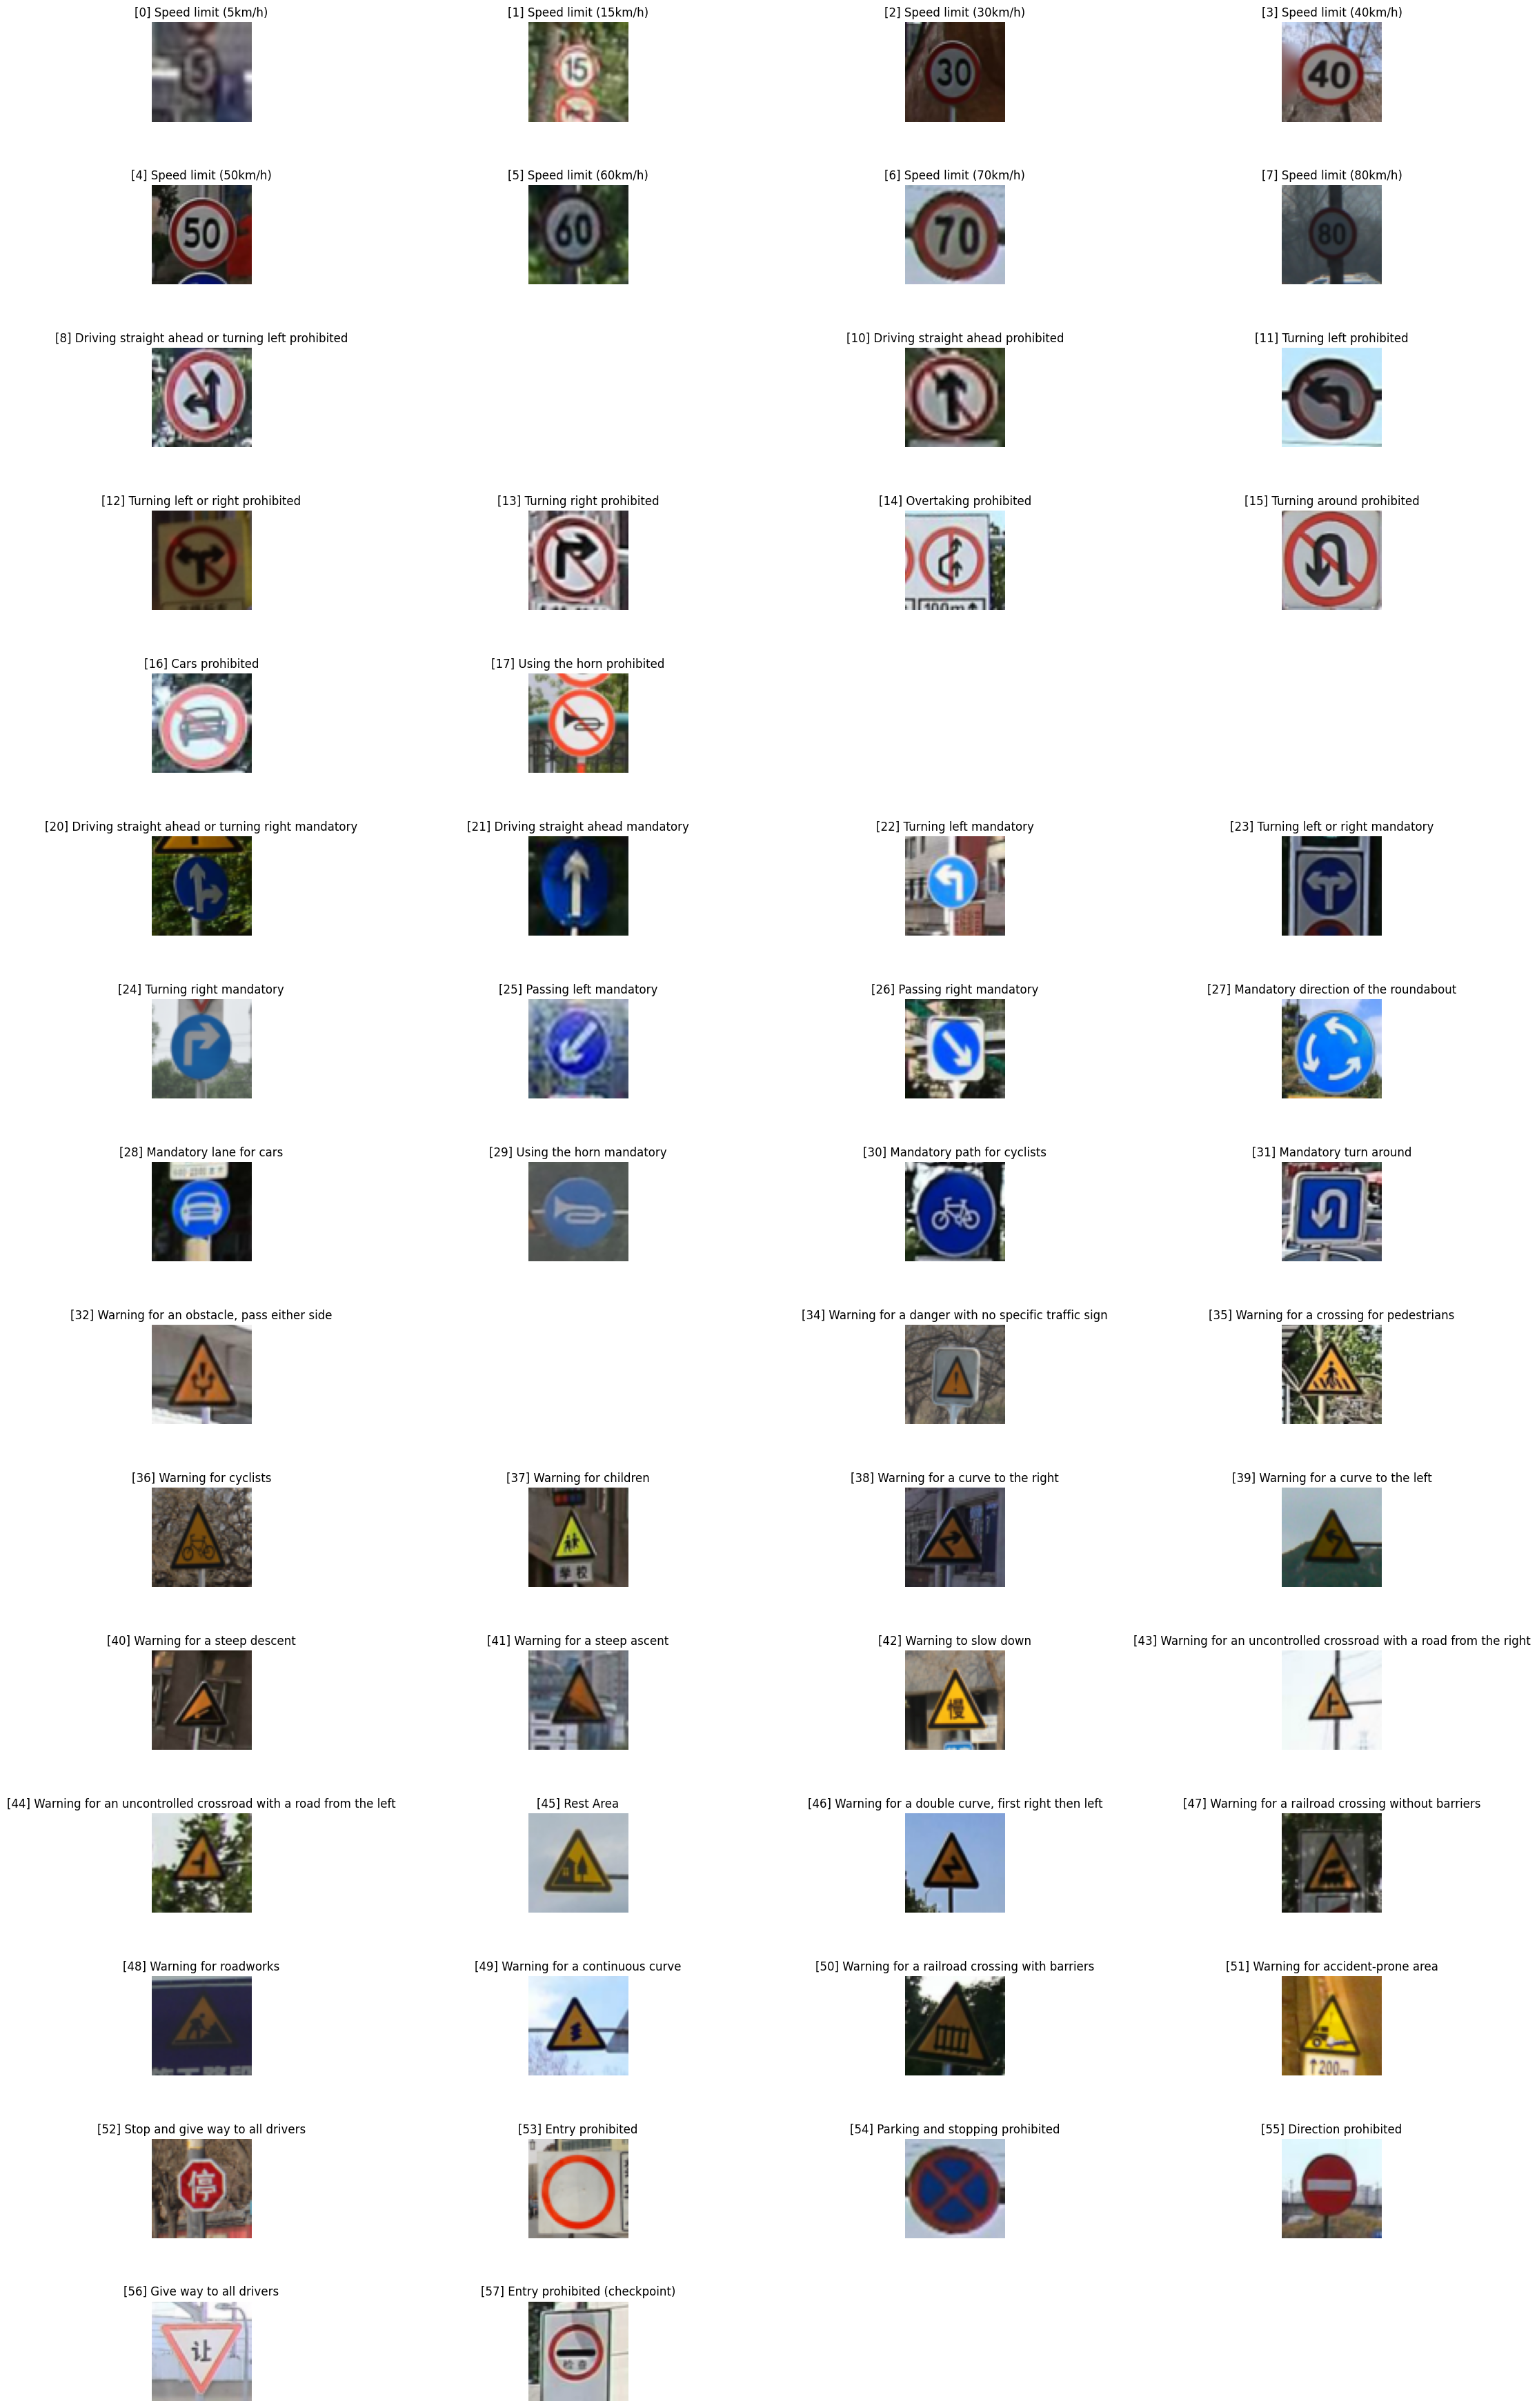

Available keys in labels_dictionary: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57])


In [39]:
# Create figure
fig = plt.figure(figsize=(22, 35), tight_layout={'h_pad': 5})

for i in range(NUM_CATEGORIES):
    # Get the indices of all occurrences of the label i
    indices = torch.where(y_test_old == i)[0]

    # Check if there are any occurrences and take the first one
    if indices.numel() > 0:
        image_key = indices[0].item()

        # Get the image tensor and permute to (H, W, C) for visualization
        img = X_test[image_key].permute(1, 2, 0).numpy()

        # Create subplot
        ax = fig.add_subplot(int(NUM_CATEGORIES / 4) + 1, 4, i + 1)
        ax.imshow(img)

        # Handle missing keys in labels_dictionary
        label_name = labels_dictionary.get(i, "Unknown Label")
        ax.set_title(f"[{i:d}] {label_name}")
        ax.axis('off')  # Hide axis for better visualization

plt.show()

# Print the keys in labels_dictionary for debugging
print("Available keys in labels_dictionary:", labels_dictionary.keys())

## Class Distribution

########################################################
- Coded by Hazel Lim Benin
########################################################

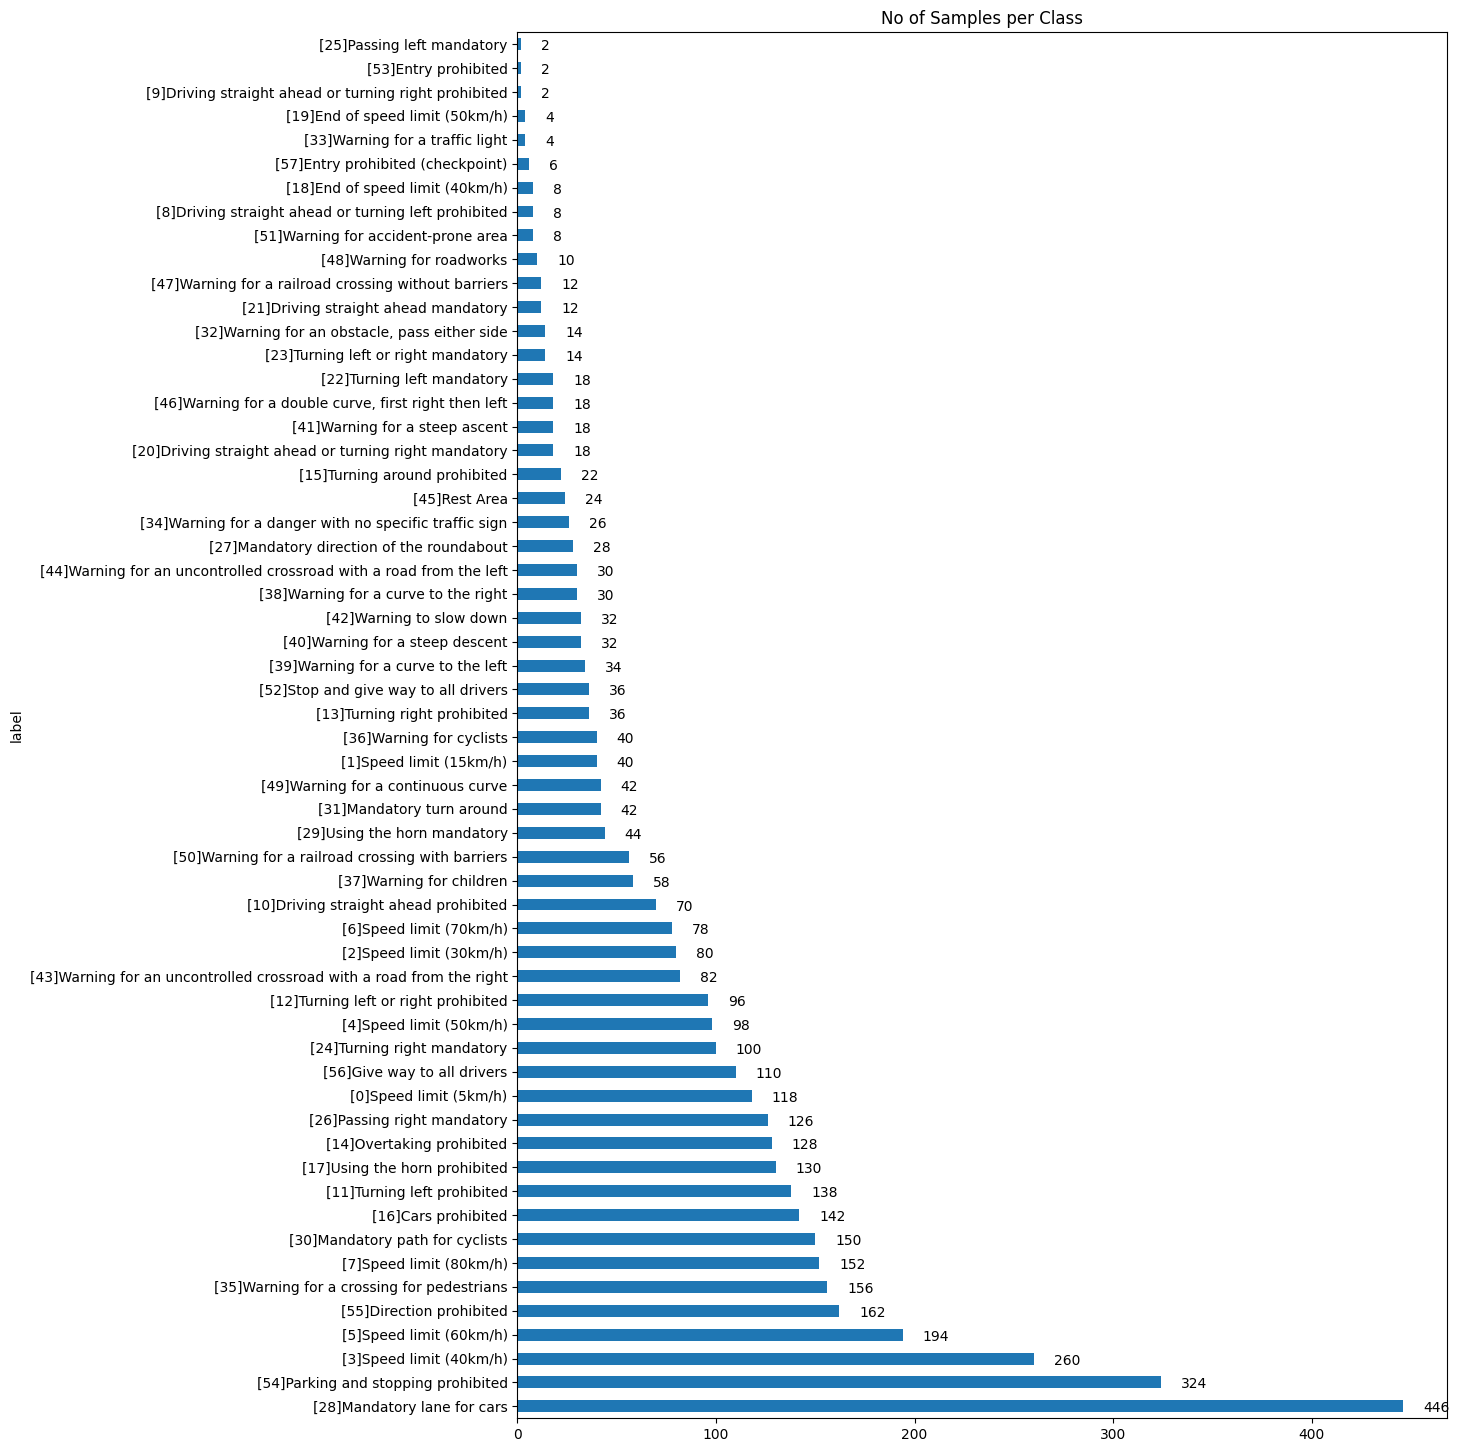

In [40]:
y_train_df = pd.DataFrame()
y_val_df = pd.DataFrame()
y_train_df['label'] = y_train_old
y_val_df['label'] = y_val_old
y_data_df = pd.concat([y_train_df, y_val_df])
ax = y_data_df['label'].value_counts().plot(kind='barh', figsize = (12,18), title='No of Samples per Class')
index_list = y_data_df['label'].value_counts().index.tolist()
ax.set_yticklabels(list(map(lambda x: f'[{x}]{labels_dictionary[x]}', index_list)))
for i, v in enumerate(y_data_df['label'].value_counts()):
    ax.text(v + 10, i - 0.25, str(v), color='black')

In [41]:
unique_labels, counts = torch.unique(y_train_old, return_counts=True)
labels_i = [[label.item(), count.item()] for label, count in zip(unique_labels, counts)]
labels_df = pd.DataFrame(labels_i, columns=['ClassId', 'Count'])
data_pd = pd.read_csv(data_path+'/mapSignnamesToClass.csv')
labels_pd = data_pd.set_index('ClassId')
labels_pd = labels_pd.join(labels_df.set_index('ClassId'))
labels_pd_sorted = labels_pd.sort_values(['Count'], ascending=False)
print(labels_pd_sorted)

                                                  SignName  Count
ClassId                                                          
28                                 Mandatory lane for cars    372
54                         Parking and stopping prohibited    250
3                                     Speed limit (40km/h)    199
5                                     Speed limit (60km/h)    158
55                                    Direction prohibited    130
35                  Warning for a crossing for pedestrians    128
7                                     Speed limit (80km/h)    120
30                             Mandatory path for cyclists    117
16                                         Cars prohibited    116
11                                 Turning left prohibited    113
17                               Using the horn prohibited    111
14                                   Overtaking prohibited    109
26                                 Passing right mandatory    105
0         

# Data Pre-processing

########################################################
- Coded by Eii Chee Hieng
########################################################

In [8]:
def apply_clahe(image):
    '''Apply Contrast Limited Adaptive Histogram Equalization (CLAHE) to each RGB channel separately.'''
    image_np = image.permute(1, 2, 0).cpu().numpy().astype('float32')

    channels = []
    for i in range(3):
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        channel = image_np[:, :, i]
        equalized_channel = clahe.apply((channel * 255).astype('uint8')) / 255.0
        channels.append(equalized_channel)

    equalized_img = torch.tensor(np.stack(channels, axis=-1)).float()

    equalized_tensor = equalized_img.permute(2, 0, 1)

    return equalized_tensor

def equalize(image_data):
    '''Apply CLAHE to a batch of images.'''
    norm = [apply_clahe(image) for image in tqdm(image_data)]
    return torch.stack(norm)

In [43]:
print('\nEqualizing Start.\n')
print('Equalizing Training Images...')
X_train_norm = equalize(X_train)
print('Equalizing Validation Images...')
X_val_norm = equalize(X_val)
print('\nEqualizing Test Images...')
X_test_norm = equalize(X_test)
print('\nEqualizing Complete.')


Equalizing Start.

Equalizing Training Images...


100%|█████████████████████████████████████| 3336/3336 [00:00<00:00, 6813.06it/s]


Equalizing Validation Images...


100%|███████████████████████████████████████| 834/834 [00:00<00:00, 6708.22it/s]



Equalizing Test Images...


100%|█████████████████████████████████████| 1994/1994 [00:00<00:00, 6573.16it/s]


Equalizing Complete.


## Data Augmentation

########################################################
- Coded by Eii Chee Hieng
########################################################

In [44]:
X_train_norm.shape

torch.Size([3336, 3, 60, 60])

In [45]:
def apply_transform(image_tensor):
    '''Apply the defined transformations to a PyTorch tensor image.'''
    # Convert tensor to PIL Image for transformation
    image_pil = transforms.ToPILImage()(image_tensor)
    # Apply the transformations
    augmented_image_pil = DATA_AUGMENTATION_SPEC(image_pil)
    return augmented_image_pil

In [46]:
max_images_per_class = MAX_NO_IMG_PER_CLASS
X_train_aug = torch.empty((0, 3, IMG_SIZE, IMG_SIZE))
y_train_aug = torch.empty(0, dtype=torch.long)

print('Augmenting Images...')
for i in tqdm(range(n_labels)):
    # Get class-specific data
    class_indices = y_train_old == i
    i_class_images = X_train_norm[class_indices]
    i_class_y = y_train_old[class_indices]

    # Initialize augmented data containers
    i_X_train_aug = []
    i_y_train_aug = []


    # Augment images
    for j in range(len(i_class_y)):
        image = i_class_images[j]
        label = i_class_y[j]


        # Apply transformation multiple times
        for _ in range(max_images_per_class // len(i_class_y)):
            augmented_image = apply_transform(image)

            i_X_train_aug.append(augmented_image)
            i_y_train_aug.append(label)

            if len(i_X_train_aug) >= max_images_per_class:
                break

    # Convert lists to tensors
    i_X_train_aug = torch.stack(i_X_train_aug)[:max_images_per_class]
    i_y_train_aug = torch.tensor(i_y_train_aug)[:max_images_per_class]

    # Append to global dataset
    X_train_aug = torch.cat((X_train_aug, i_X_train_aug), dim=0)
    y_train_aug = torch.cat((y_train_aug, i_y_train_aug), dim=0)

# Shuffle the augmented data
X_train_aug, y_train_aug = shuffle(X_train_aug.numpy(), y_train_aug.numpy(), random_state=113)
X_train_aug = torch.tensor(X_train_aug)
y_train_aug = torch.tensor(y_train_aug)

print('Augmentation Complete.\n')
print('New number of training images: ', X_train_aug.shape[0])

Augmenting Images...


100%|███████████████████████████████████████████| 58/58 [02:08<00:00,  2.21s/it]


Augmentation Complete.

New number of training images:  172895


### Summary
########################################################
- Coded by Hazel Lim Benin
########################################################

In [47]:
print("Number of training examples =", len(X_train_aug))
print("Number of validation examples =", len(X_val))
print("Number of test examples =", len(X_test))
print("Image data shape =", X_train_aug.shape[1:])
print("Number of labels/classes =", NUM_CATEGORIES)

Number of training examples = 172895
Number of validation examples = 834
Number of test examples = 1994
Image data shape = torch.Size([3, 60, 60])
Number of labels/classes = 58


### Comparison before & after normalize
########################################################
- Coded by Hazel Lim Benin
########################################################

label index:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])


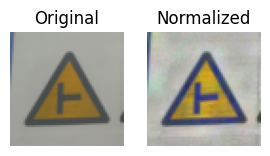

In [48]:
index = random.randint(0, len(X_train_norm))

image_orig = X_train[index].squeeze()
image_orig = image_orig.permute(1, 2, 0).cpu().numpy().astype('float32')
image_norm = X_train_norm[index].squeeze()
image_norm = image_norm.permute(1, 2, 0).cpu().numpy().astype('float32')

plt.figure(figsize=(5,5))

plt.subplot2grid((1, 3), (0, 0));
plt.axis('off')
plt.title('Original')
plt.imshow(image_orig, cmap="gray")

plt.subplot2grid((1, 3), (0, 1));
plt.axis('off')
plt.title('Normalized')
plt.imshow(image_norm, cmap="gray")


print('label index: ', Y_train[index])

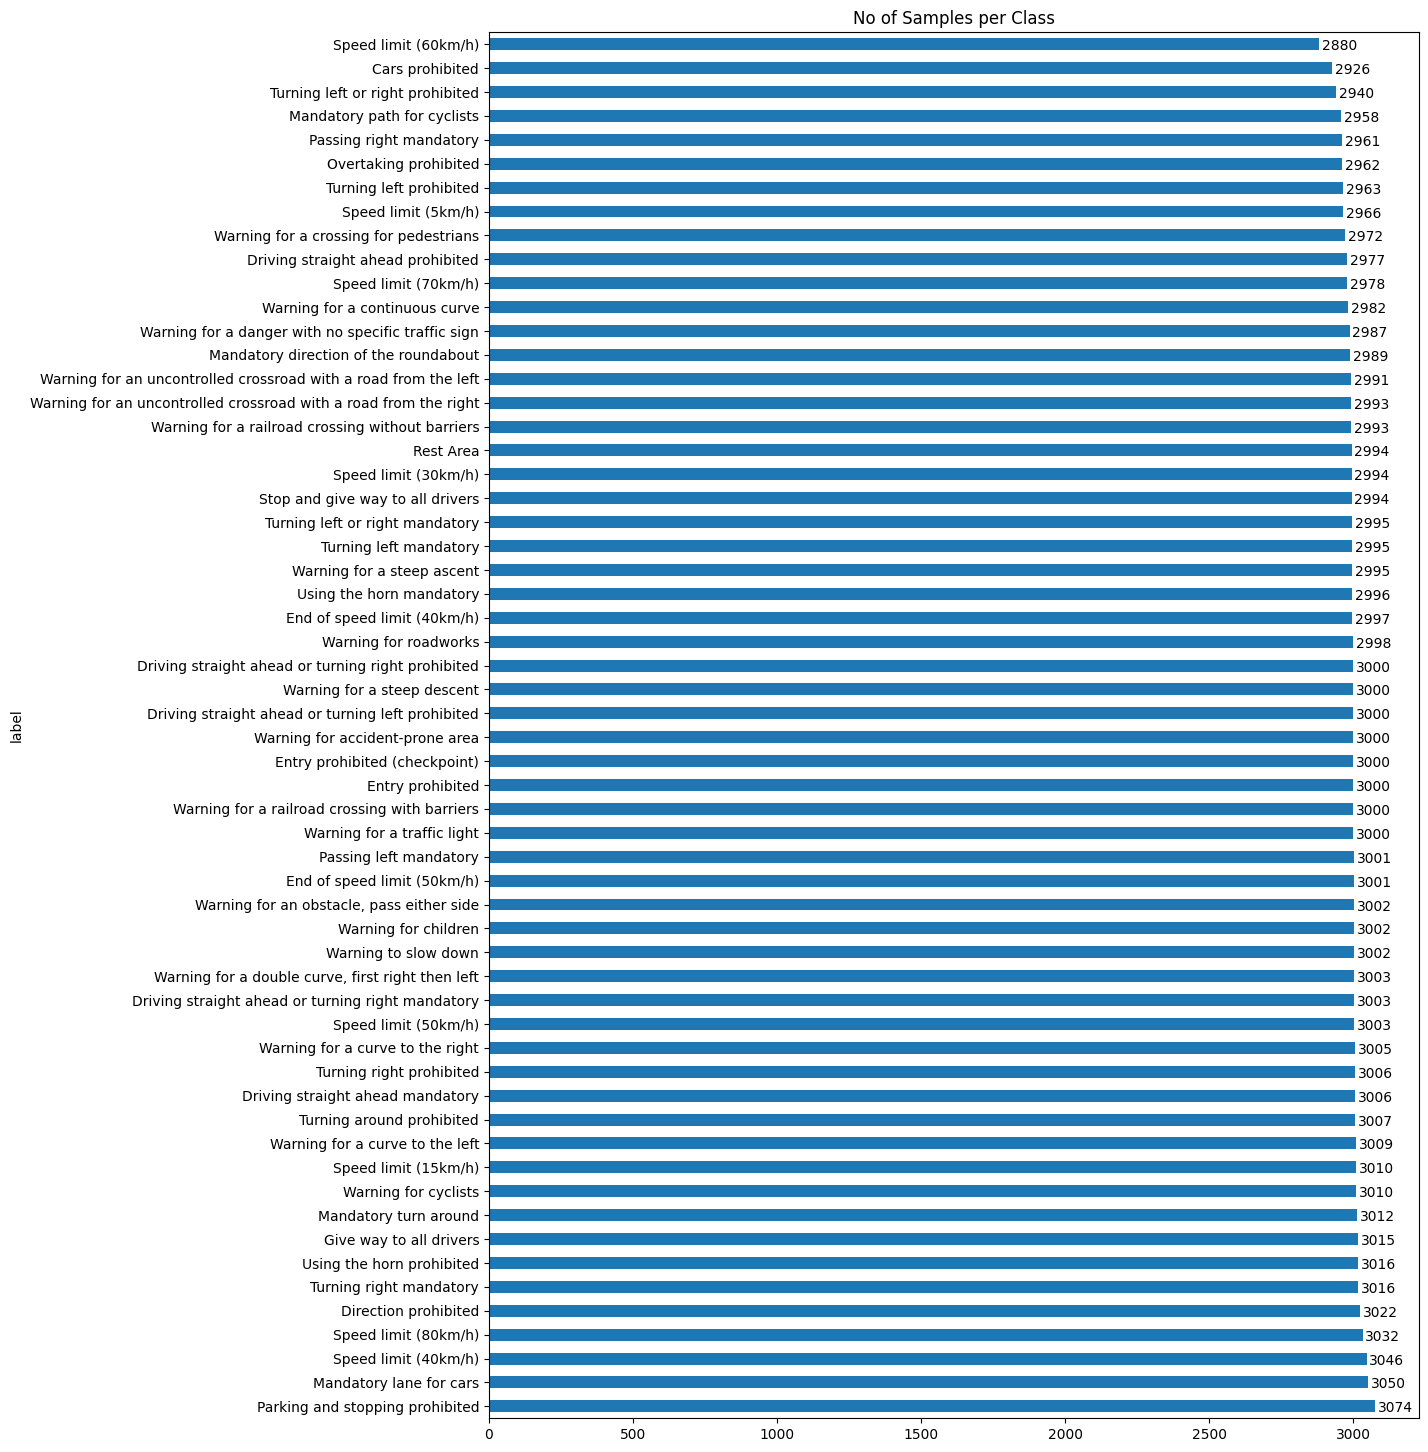

In [49]:
y_train_df = pd.DataFrame()
y_val_df = pd.DataFrame()
y_train_df['label'] = y_train_aug
y_val_df['label'] = y_val_old
y_data_df = pd.concat([y_train_df, y_val_df])
ax = y_data_df['label'].value_counts().plot(kind='barh', figsize = (12,18), title='No of Samples per Class')
ax.set_yticklabels(list(map(lambda x: labels_dictionary[x], y_data_df['label'].value_counts().index.tolist())))
for i, v in enumerate(y_data_df['label'].value_counts()):
    ax.text(v + 10, i - 0.25, str(v), color='black')

In [50]:
# Clone the augmented and normalized datasets
X_train = X_train_aug.clone()
y_train = y_train_aug.clone()
X_val = X_val_norm.clone()
X_test = X_test_norm.clone()

# Print the shapes of the datasets
print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", Y_val.shape)

X_train.shape torch.Size([172895, 3, 60, 60])
X_valid.shape torch.Size([834, 3, 60, 60])
y_train.shape torch.Size([172895])
y_valid.shape torch.Size([834, 58])


########################################################
- Coded by Ong Chan Meng
########################################################

In [51]:
# # One hot encoding new training set

y_train = nn.functional.one_hot(y_train, num_classes=NUM_CATEGORIES).float()

print(y_train.shape)

torch.Size([172895, 58])


In [52]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [53]:
Y_test = nn.functional.one_hot(torch.tensor(test_labels), NUM_CATEGORIES).float()
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, Y_val)
test_dataset = CustomDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

# Model Training

########################################################
- Adapted from UCCD3074 Practical 5
########################################################

In [54]:
def train(net, trainloader, device, num_epochs=NUM_EPOCH, lr=LEARNING_RATE, step_size=STEP_SIZE, gamma=DECAY_RATE):
    criterion = nn.BCEWithLogitsLoss() 
    optimizer = optim.Adam(net.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []

    model = net.to(device)

    print(f'Training device: {device}')

    for epoch in range(num_epochs):
        print('-' * 20)
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 20)
        
        start_time = time.time()

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in trainloader[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

                running_corrects += torch.sum(preds == torch.argmax(labels, dim=1))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]
            print(f'[{phase}] Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

        scheduler.step()
        
        test_accuracy = evaluate_accuracy(model, test_loader, device)
        print(f'Test Acc: {test_accuracy:.4f}\n')
        test_accuracies.append(test_accuracy)
        epoch_time = time.time() - start_time
        print(f'Epoch {epoch+1} completed in {epoch_time:.2f} seconds\n')

    print('Training complete')
    return train_losses, train_accuracies, val_losses, val_accuracies, test_accuracies

########################################################
- Coded by Eii Chee Hieng
########################################################

In [9]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=16, kernel_size=3, padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        self.conv2_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.conv4_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2)
        self.conv3_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.6)
        
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv5_6 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, padding=1)
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.dropout2 = nn.Dropout(0.7)

        self.fc1 = nn.Linear(256 * 7 * 7, 128)
        self.dropout3 = nn.Dropout(0.6)
        self.fc2 = nn.Linear(128, NUM_CATEGORIES)


    def forward(self, x):
        # Forward pass
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv2_1(x))
        x = self.batchnorm1(x)
        x = self.pool1(x)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv3_1(x))
        x = self.pool2(x)
        x = self.batchnorm2(x)
        x = self.dropout1(x)
        
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv5_6(x))
        x = self.avgpool(x)
        
        x = self.batchnorm3(x)
        x = self.dropout2(x)
    
        # Flattening the output
        x = torch.flatten(x, 1)
    
        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
    
        return x

In [209]:
model = CustomModel()
summary(model, input_size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE))

torch.Size([32, 256, 14, 14])
Shape before flattening: torch.Size([32, 256, 7, 7])


Layer (type:depth-idx)                   Output Shape              Param #
CustomModel                              [32, 58]                  --
├─Conv2d: 1-1                            [32, 16, 58, 58]          448
├─Conv2d: 1-2                            [32, 32, 58, 58]          12,832
├─Conv2d: 1-3                            [32, 32, 58, 58]          25,632
├─BatchNorm2d: 1-4                       [32, 32, 58, 58]          64
├─MaxPool2d: 1-5                         [32, 32, 29, 29]          --
├─Conv2d: 1-6                            [32, 32, 29, 29]          9,248
├─Conv2d: 1-7                            [32, 64, 29, 29]          51,264
├─Conv2d: 1-8                            [32, 64, 29, 29]          102,464
├─Conv2d: 1-9                            [32, 64, 29, 29]          36,928
├─MaxPool2d: 1-10                        [32, 64, 14, 14]          --
├─BatchNorm2d: 1-11                      [32, 64, 14, 14]          128
├─Dropout: 1-12                          [32, 64, 14, 14]  

In [56]:
print(torch.backends.mps.is_available())

True


In [10]:
def evaluate_accuracy(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            model = model.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the predicted class labels

            # Convert one-hot encoded labels to class indices if needed
            if labels.dim() > 1:  # Check if labels are one-hot encoded
                labels = labels.argmax(dim=1)  # Convert to class indices

            total += labels.size(0)  # Update the total number of samples
            correct += (predicted == labels).sum().item()  # Update the number of correct predictions

    accuracy = correct / total  # Calculate accuracy
    return accuracy

In [121]:
history = train(model, dataloaders, device)

Training device: mps
--------------------
Epoch 1/30
--------------------
[train] Loss: 0.0340 Acc: 0.7129
[val] Loss: 0.0009 Acc: 0.9952
Test Acc: 0.8616

Epoch 1 completed in 298.26 seconds

--------------------
Epoch 2/30
--------------------
[train] Loss: 0.0046 Acc: 0.9751
[val] Loss: 0.0000 Acc: 1.0000
Test Acc: 0.9458

Epoch 2 completed in 249.70 seconds

--------------------
Epoch 3/30
--------------------
[train] Loss: 0.0024 Acc: 0.9901
[val] Loss: 0.0000 Acc: 1.0000
Test Acc: 0.9519

Epoch 3 completed in 251.26 seconds

--------------------
Epoch 4/30
--------------------
[train] Loss: 0.0018 Acc: 0.9937
[val] Loss: 0.0000 Acc: 1.0000
Test Acc: 0.9478

Epoch 4 completed in 250.89 seconds

--------------------
Epoch 5/30
--------------------
[train] Loss: 0.0015 Acc: 0.9948
[val] Loss: 0.0000 Acc: 1.0000
Test Acc: 0.9569

Epoch 5 completed in 249.41 seconds

--------------------
Epoch 6/30
--------------------
[train] Loss: 0.0013 Acc: 0.9962
[val] Loss: 0.0000 Acc: 1.0000
Te

In [59]:
test_accuracy = evaluate_accuracy(model, test_loader, device)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.9799


In [223]:
def plot_graph(train_losses, val_losses, train_accuracies, val_accuracies, test_accuracies):
    
    epochs = range(1, len(train_losses) + 1)

    # Plotting loss
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plotting accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.plot(epochs, test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

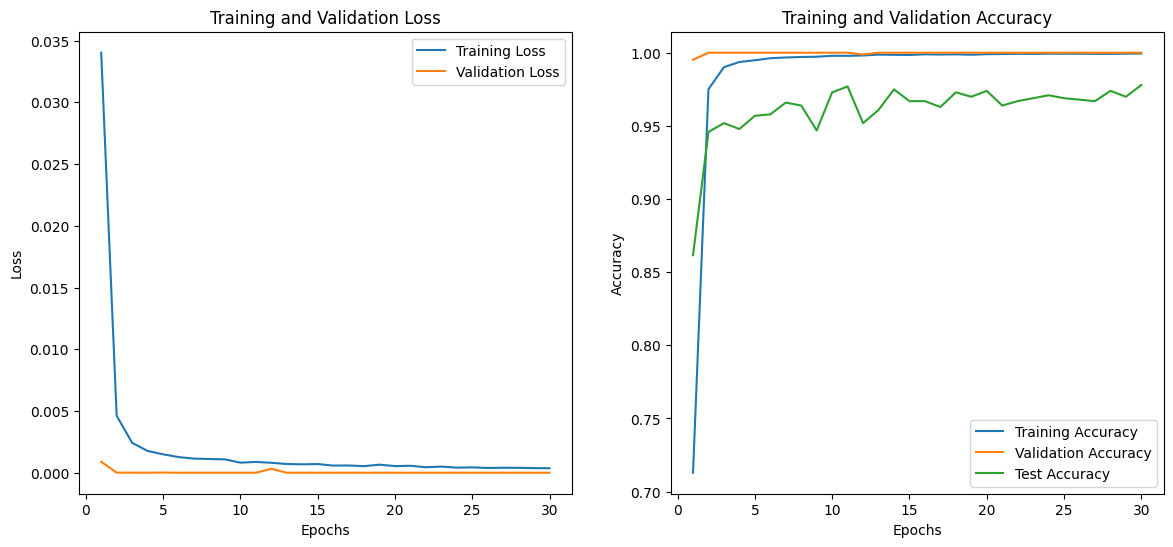

In [224]:
train_losses, train_accuracies, val_losses, val_accuracies, test_accuracies = history

train_losses = torch.tensor(train_losses).to(torch.device("cpu"))
val_losses = torch.tensor(val_losses).to(torch.device("cpu"))
train_accuracies = torch.tensor(train_accuracies).to(torch.device("cpu"))
val_accuracies = torch.tensor(val_accuracies).to(torch.device("cpu"))
test_accuracies = torch.tensor(test_accuracies).to(torch.device("cpu"))

plot_graph(train_losses, val_losses, train_accuracies, val_accuracies, test_accuracies)

### Confusion Matrix
########################################################
- Coded by Eii Chee Hieng
########################################################

In [225]:
def display_confusion_matrix(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    all_predicted = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the predicted class labels

            # Convert one-hot encoded labels to class indices if needed
            if labels.dim() > 1:  # Check if labels are one-hot encoded
                labels = labels.argmax(dim=1)  # Convert to class indices

            all_predicted.append(predicted.cpu())
            all_labels.append(labels.cpu())

    all_predicted = torch.cat(all_predicted)
    all_labels = torch.cat(all_labels)

    class_labels = list(range(NUM_CATEGORIES))
    
    # Compute the confusion matrix
    conf_matrix = confusion_matrix(all_labels.numpy(), all_predicted.numpy(), labels=class_labels)
    
    # Display the confusion matrix
    plt.figure(figsize=(14, 14))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

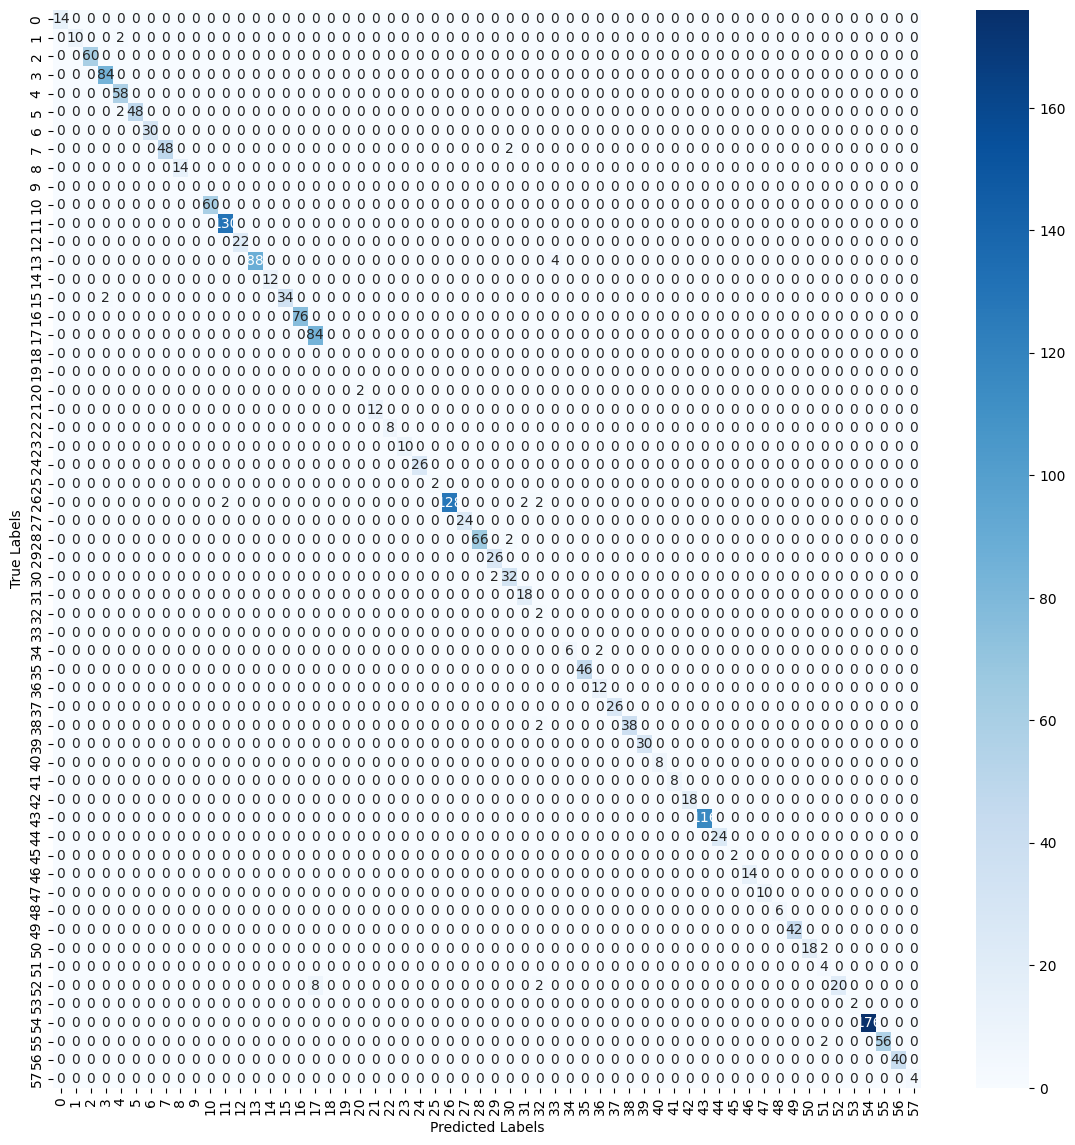

In [260]:
display_confusion_matrix(model, test_loader, device)

### Scores

In [76]:
def display_scores(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    all_predicted = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            # Apply sigmoid and threshold to get binary predictions
            predicted = torch.sigmoid(outputs) > 0.5

            # Append to the lists
            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays
    all_predicted = np.array(all_predicted)
    all_labels = np.array(all_labels)

    # Compute the classification report
    report = classification_report(all_labels, all_predicted, output_dict=True, zero_division=0)

    metrics_to_show = ['micro avg', 'macro avg', 'weighted avg', 'samples avg']
    filtered_report = {metric: report[metric] for metric in metrics_to_show if metric in report}

    # Convert the filtered report to a pandas DataFrame
    report_df = pd.DataFrame(filtered_report).transpose()

    # Print the filtered report in a table format
    print(report_df.to_string())

In [77]:
display_scores(model, test_loader, device)

              precision    recall  f1-score  support
micro avg      0.995803  0.951856  0.973333   1994.0
macro avg      0.928725  0.872620  0.895777   1994.0
weighted avg   0.998003  0.951856  0.972250   1994.0
samples avg    0.951856  0.951856  0.951856   1994.0


In [126]:
# Save the entire model
torch.save(model, 'model_full.pth')

In [11]:
model = torch.load('model_full.pth')
model.to(device)
model.eval()  
print(model)

CustomModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_1): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4_1): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.6, inplace=False)
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), strid

# Testing with External Data Set
########################################################
- Coded by Eii Chee Hieng
########################################################

- Dataset: CATSD - https://github.com/icfaust/CATSAD/tree/main
- Reason of selection: It is Chinese Traffic Sign Dataset, matched with TSRD
- Missing Class: 33
- The dataset with class that not available in TSRD is removed
- the filename is renamed as xxx_i.png, xxx is the class code and i is index

In [12]:
eTest_image_data = []
eTest_image_labels = []

images = os.listdir(EXTERNAL_TEST_PATH)

transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor()
])

for img in images:
  # Skip macOS hidden file
  if img.split('_')[0] == '.DS':
      continue

  # Obtain image's class
  i = int(img.split('_')[0])
  try:
      image = cv2.imread(os.path.join(EXTERNAL_TEST_PATH, img))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = Image.fromarray(image, 'RGB')

      # Apply transformations if any
      if transform:
          image = transform(image)

      # STORE IMAGE AND IT'S LABEL
      eTest_image_data.append(image)
      eTest_image_labels.append(i)
  except Exception as e:
      print(f"Error in {img}: {e}")

print(len(eTest_image_data), len(eTest_image_labels))

55171 55171


In [12]:
X_etest = equalize(eTest_image_data)

100%|███████████████████████████████████| 55171/55171 [00:08<00:00, 6669.55it/s]


In [17]:
Y_etest = nn.functional.one_hot(torch.tensor(eTest_image_labels), NUM_CATEGORIES).float()
etest_dataset = CustomDataset(X_etest.clone(), Y_etest)

etest_loader = DataLoader(etest_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [20]:
etest_accuracy = evaluate_accuracy(model, etest_loader, device)
print(f'Test Accuracy: {etest_accuracy:.4f}')

Test Accuracy: 0.8189


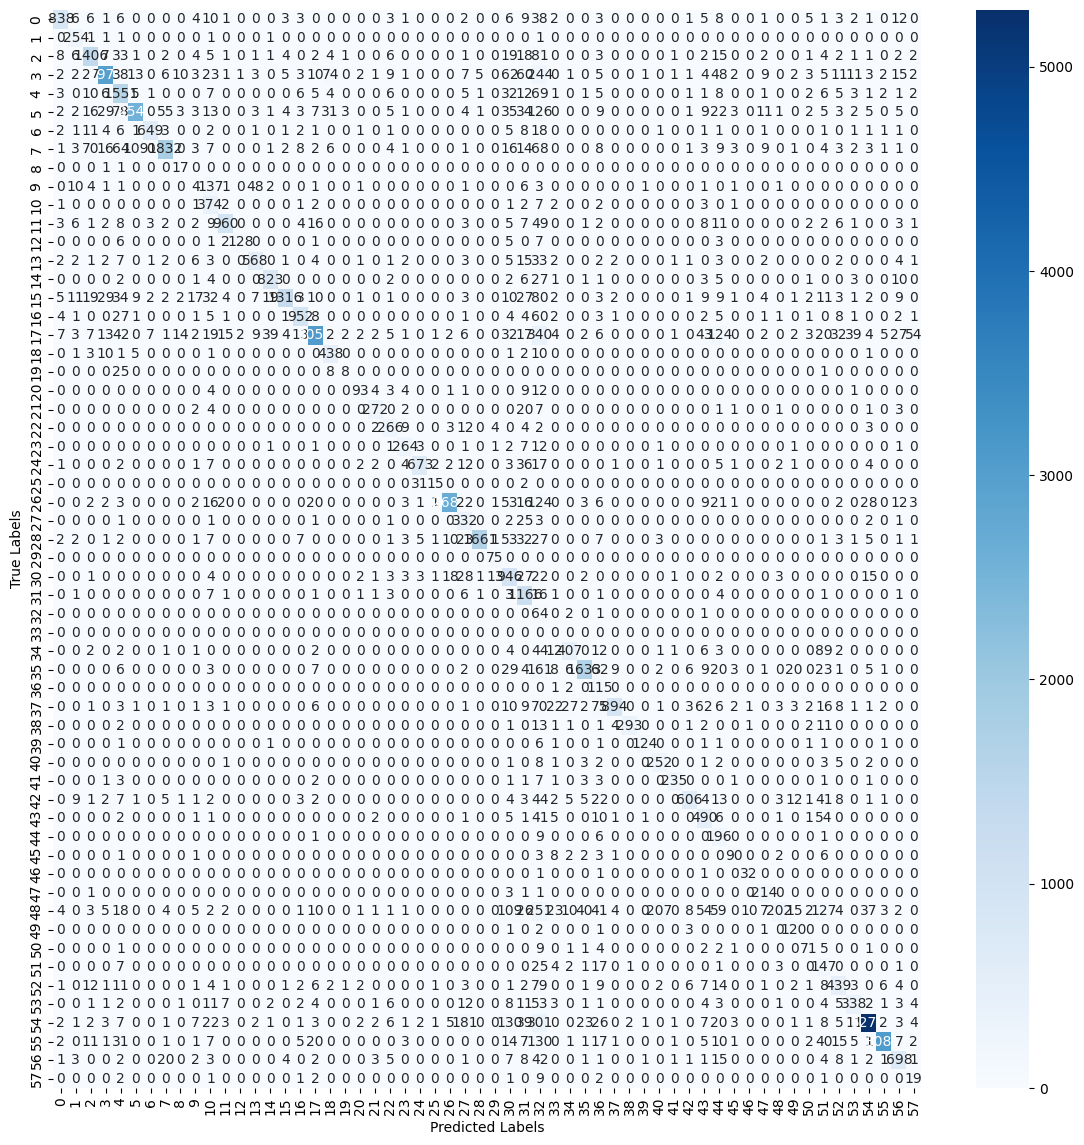

In [23]:
display_confusion_matrix(model, etest_loader, device)

# GUI
########################################################
- Coded by Eii Chee Hieng
########################################################

In [ ]:
# Import necessary libraries
import tkinter as tk
from tkinter import *
from tkinter import filedialog
from PIL import Image, ImageTk


# User Interface
BACKGROUND_COLOR = '#FFF'
FOREGROUND_COLOR = '#000'

# Interface
top = tk.Tk()
top.geometry('800x600')
top.title('Traffic Sign Classification System')
top.configure(background=BACKGROUND_COLOR)

# Heading
heading = Label(top, text="TRAFFIC SIGN CLASSIFICATION",
                pady=20, font=('MS Sans Serif', 22, 'bold'))
heading.configure(background=BACKGROUND_COLOR, foreground=FOREGROUND_COLOR)
heading.pack()

# Frame for button section
btn_frame = Frame(top, background=BACKGROUND_COLOR)
btn_frame.pack()
btn_frame.place(anchor='e', relx=0.95, rely=0.5)

classify_btn_frame = Frame(btn_frame, background=BACKGROUND_COLOR)
classify_btn_frame.pack(side=TOP)

# Frame for Image section
image_frame = Frame(top, width=400, height=400, background=BACKGROUND_COLOR)
image_frame.pack()
image_frame.place(anchor='w', relx=0.15, rely=0.5)

sign_image = Label(image_frame, background=BACKGROUND_COLOR)
sign_image.pack(side=TOP, pady=10)

label = Label(image_frame, background=BACKGROUND_COLOR,
              foreground=FOREGROUND_COLOR, font=('MS Sans Serif', 17))
label.pack(side=BOTTOM)

transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor()
])

# Predict the class
def classify(file_path):
    model.to(device)
    global label_packed
    image = cv2.imread(file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image, 'RGB')
    
    if transform:
        image = transform(image)  # Apply transformations
    image = image.unsqueeze(0)  # Add batch dimension
    image = image.float()
    image = image.to(device)

    with torch.no_grad():
        print(f"Model device: {next(model.parameters()).device}")
        print(f"Image device: {image.device}")
        output = model(image)
        pred = torch.argmax(output, dim=1)
        result = pred.item()
        sign = labels_dictionary[result]
        print(sign)
        label.configure(text=sign)


# Show classify button when image is uploaded
def show_classify_button(file_path):
    classify_btn.configure(command=lambda: classify(file_path))
    classify_btn.pack(side=TOP)


# Upload Image Function
def upload_image():
    try:
        file_path = filedialog.askopenfilename()
        uploaded = Image.open(file_path)
        uploaded = uploaded.resize((400, 300))
        im = ImageTk.PhotoImage(uploaded)
        sign_image.configure(image=im)
        sign_image.image = im
        label.configure(text='')
        show_classify_button(file_path)
    except Exception as e:
        print(f"Error loading image: {e}")
        pass


upload_btn = Button(btn_frame, text="Insert Image", command=upload_image)
upload_btn.configure(background=BACKGROUND_COLOR,
                     foreground=FOREGROUND_COLOR, font=('Courier New', 12, 'bold'))
upload_btn.pack(side=BOTTOM)

classify_btn = Button(classify_btn_frame, text="Classify Sign")
classify_btn.configure(background=BACKGROUND_COLOR,
                       foreground=FOREGROUND_COLOR, font=('Courier New', 12, 'bold'))

top.mainloop()

2024-09-10 15:03:14.105 Python[3664:211171] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


Model device: mps:0
Image device: mps:0
Mandatory path for cyclists
Model device: mps:0
Image device: mps:0
Warning to slow down
Model device: mps:0
Image device: mps:0
Driving straight ahead mandatory
